Script to automate data preprocessing. 

### Imports

In [17]:
# Import time
import time

# Numpy imports:    
import numpy as np

# Pandas for csv 
import pandas as pd

# for extracting filenames 
import glob

#Matplotlib imports
import matplotlib.pyplot as plt

# skimage submodules we need
import skimage.io

#Scipy imports
import scipy
from scipy import optimize
from scipy.optimize import curve_fit

import os

import atp_hydro
atp_hydro.pboc_style_mpl()
# show images in viridis by default (pboc is fire?)
plt.rcParams['image.cmap'] = 'viridis'

# Import seaborn for aesthetic plots 
import seaborn as sns

from tqdm.notebook import tqdm

In [18]:
data_location = "../../data/atp_hydro/1000uM_ATP_0_ADP_0_P/"; # Specify data location

# Old Preprocessing Pipeline

### Find Files

Input imaging parameters to get time steps right

In [19]:
frame_int = 20 #s
Motconc = 1 #uM, NCD Motors 
skip_int = 5 #data frames to skip 

# Declare where data is stored 
datapath = '/Volumes/Najma/'

# Declaring folders to iterate over
datafolders = ['ATP/', 'ADP/', 'Phosphate/']; 
datafolders = ['ATP/']; # Picking one datafolder at a time makes processing easier. 

Function to find all file paths that have folders that contain tiff files. This makes it easier to locate the subfolders that contain the tiff files.

In [20]:
# Function to find all file paths that have folders that contain tiff files. This makes it easier to locate the subfolders that contain the tiff files.
def find_file_paths(root_dir, file_name, result=None):
    if result is None:
        result = []

    # Iterate over all files and directories in the current directory
    for item in os.listdir(root_dir):
        item_path = os.path.join(root_dir, item)

        # Check if the current item is a file with the desired name
        if os.path.isfile(item_path) and file_name in item:
            result.append("/".join(item_path.split('/')[:-1]))
            break

        # Check if the current item is a directory, then recurse into it
        elif os.path.isdir(item_path):
            find_file_paths(item_path, file_name, result)

    return result



### Analyze Data

In [21]:
# Function that calls automated data processing function from atp hydro packages

def read_images(datafolder, skip_int = 1):
    # bound Images
    included_bound = '*405*.tif'
    bound_files = np.sort(glob.glob(datafolder+'/'+included_bound))[::skip_int]
    bound_images = [skimage.io.imread(image_location) for image_location in bound_files]; 
    # unbound Images
    included_unbound = '*480*.tif'
    unbound_files = np.sort(glob.glob(datafolder+'/'+included_unbound))[::skip_int]
    unbound_images = [skimage.io.imread(image_location) for image_location in unbound_files]; 

    return bound_images, unbound_images

In [22]:
def grab_dark_avg(file_path_dark):
    """
    Imports a dark image.
 
    Parameters:
    file_path_dark (string): Data path for a dark image.
    
    Returns:
    dark_avg (numpy.ndarray): Dark image as a 2D array.
    """
    dark_files = np.sort(glob.glob(file_path_dark))
    dark_ims = np.array([skimage.io.imread(image_location) for image_location in dark_files]); 
    dark_avg = np.average(dark_ims, axis=0)
    return dark_avg


#### Functions relating to correcting uneven illumination

In [ ]:
# def intersect(arrs):
#     """
#     The camera has an occasional jitter, illuminating slightly different fields of view. This function finds pixels illluminated in all frames
    
#     Parameters:
#     arrs (lsit): list of 3D numpy.ndarray's containing aster images where each array is from a different fluorescent channel.
    
#     Returns:
#     (tuple): tuple containing the pixel coordinates for pixels illuminated in all images. The tuple has two 1D arrays, one for each image dimension.
#     """
#     _, numRows, numCols=arrs[0].shape
    
#     #iterate through frame numbers
#     severeIntersection=np.ones_like(arrs[0][0]);
    
#     for fr in range(arrs[0].shape[0]): # for every timepoint
#         #iterate through channels:
#         ## Process the ATP channels first!
#         im_bins=[]
#         for arr in arrs[:2]: #exclude the motor channel!
#             im_bin = (arr[fr,:,:] > threshold_otsu(arr[fr,:,:])).astype(np.uint8)
#             im_bins.append(im_bin)
#         intersectionBinImg=np.multiply(*im_bins) # This is defined for each frame/timepoint; it is the intersection between both channels' masks
#         severeIntersection=np.multiply(severeIntersection, intersectionBinImg) # This accumulates the most severe intersection possible such that after iteration over all frames, all pixels not = 0 are visible/illuminated in every frame and every channel

#     return np.where(severeIntersection.astype(int)) #returns where =1 (or True)


def fit_bivariate_quadratic(image):
    """
    Fits a bivariate quadratic polynomial to the intensity values of a grayscale image.
    
    Parameters:
    image (numpy.ndarray): Grayscale image of shape (M, N).
    
    Returns:
    coefficients (numpy.ndarray): Coefficients of the fitted polynomial [a00, a10, a01, a20, a11, a02].
    """
    # Get image dimensions
    M, N = image.shape

    # Create a meshgrid of coordinates
    i = np.arange(M)
    j = np.arange(N)
    I, J = np.meshgrid(i, j, indexing='ij')

    # Flatten the matrices for the least squares fitting
    I_flat = I.flatten()
    J_flat = J.flatten()
    Z_flat = image.flatten()

    # Create the design matrix for the polynomial terms
    A = np.vstack([I_flat**2, J_flat**2, I_flat*J_flat, I_flat, J_flat, np.ones_like(I_flat)]).T

    # Solve for the coefficients using least squares
    coefficients, _, _, _ = np.linalg.lstsq(A, Z_flat, rcond=None)

    return coefficients

def evaluateBivPoly(image):
    """ Evaluates best-fit bivariate polynomial for image. """
    coefficients=fit_bivariate_quadratic(image);
    I, J = np.meshgrid(np.arange(image.shape[0]), np.arange(image.shape[1]), indexing='ij')
    Z_fitted = (coefficients[0] * I**2 + coefficients[1] * J**2 +
            coefficients[2] * I * J + coefficients[3] * I +
            coefficients[4] * J + coefficients[5])
    return Z_fitted

def norm_unev(arrs_sub):
    """
    Corrects uneven illumination by fitting an image to a bivariate polynomial, normalizing the polynomial, and dividing an array of images by this normalized matrix.
    
    Parameters:
    arrs_sub (list): Dark image subtracted list of image arrays.
    allmask_coords (slice): slice containing all the illumination coordinates with an extra dimension to account for all timepoints
    
    Returns:
    arr_ev (list): list of image arrays after the evening process.
    """
    #norm_mats = []
    arrs_ev = []
    
    for arr in arrs_sub: # Iterate over channels
        print("time before polynomial fitting", time.time()); 
        #compute the bivariate filter
        biv_filt = np.zeros_like(arr[0]) 
        biv_filt = evaluateBivPoly(arr[0, :, :])
        #norm_mats.append(norm_mat)
        print("time after polynomial fitting", time.time());
        #scale the normalization matrix such that the average value after multiplication is the same as the bs image

        scalar = np.mean(arr[0])/np.mean(arr[0]/biv_filt)

        # Normalisation
        norm_mat = scalar/biv_filt
        print("shape of norm mat", norm_mat.shape)
        print("shape of arr", arr.shape)
        print("time after normalising matrix", time.time());

        arrs_ev_temp = np.zeros_like(arr)
        arrs_ev_temp=arr*norm_mat; 
        print("time after multiplying arr with norm_mat", time.time());
        
        arrs_ev.append(arrs_ev_temp)
        print("time after appending", time.time());
        
    return arrs_ev

#### Functions relating to ratio calculation

In [ ]:
def grab_calparams(file_path_cal):
    """
    Imports ATP calibration parameters as a DataFrame.
    
    Parameters:
    file_path_cal (string): Data path to a text file with fitting parameters for ATP calibration
    
    Returns:
    cal_params (pd.DataFrame): DataFrame with ATP calibration fitting parameters.
    """
        
    #read the DataFrame
    #cal_params = pd.read_csv(cal_file_path+cal_file_folder+cal_file_name)\
    cal_params = pd.read_csv(file_path_cal)

    #add hill=1 if no hill specified
    if len(cal_params)==3:
        cal_params.loc[-1] = [3, 'nhill', 1, 0]
    
    #reindex
    cal_params = cal_params.set_index('Param')
    
    #drop the unnamed colum (from index of text file)
    cal_params = cal_params.drop(columns='Unnamed: 0')
    
    return cal_params

def replace_out_of_range_values(arr, min_value, max_value):
    """
    Crop the intensities of an array to be withing a defined range.
    
    Parameters:
    arr (numpy.ndarray): images array.
    min_value (float): minimum value below which all other values are set to the minimum
    max_value (float): maximum value above which all other values are set to the maximum
    
    Returns:
    arr_copy (numpy.ndarray): image array cropped to the set intensity range.
    """
    arr_copy = np.copy(arr)
    mask_min = arr < min_value
    mask_max = arr > max_value
    arr_copy[mask_min] = min_value
    arr_copy[mask_max] = max_value
    return arr_copy

def ATP_conc_to_ratio(array, Km, Rmax, Rmin, nhill):
    """Given a set of concentrations, returns ratio values based on provided Hill equation coefficients"""
    return (Rmax-Rmin)*((array/Km)**nhill/(1 + (array/Km))**nhill) + Rmin

def ATP_ratio_to_conc(array, Km, Rmax, Rmin, nhill):
    """Given a set of ratios, returns concentration values based on provided Hill equation coefficients"""
    return Km * ((Rmin - array) / (array - Rmax)) ** (1/nhill)

def infer_concs(ratios, exp_params, cal_params, shape):
    """
    Convert ratios images to concentrations. (outputs an image array)
    
    Parameters:
    ratios (numpy.ndarray): ratio array of shape (# timepoints, #of ratio values to convert).
    exp_params (dictionary): dictonary of experimental parameters
    cal_params (dictionary): maximum value above which all other values are set to the maximum
    allmask_coords (slice): coordinates for multiple timepoints 
    shape (tuple): shape of image array
    
    Returns:
    ratios_conc_ims (numpy.ndarray): image array in concentration units.
    """
    #Find the ratio value for the inital ATP conc value based on calibration curve equation

    print("Find the ratio value for the inital ATP conc value based on calibration curve equation")
    RinitATP = ATP_conc_to_ratio(exp_params['ATP_conc'], 
                                 cal_params.loc['Km']['Value'], 
                                 cal_params.loc['Rmax']['Value'],
                                 cal_params.loc['Rmin']['Value'], 
                                 cal_params.loc['nhill']['Value'])
    #Crop the ratios to within range
    print("Crop the ratios to within range")
    ratios_inrange = replace_out_of_range_values(ratios, 
                                                 cal_params.loc['Rmin']['Value'], 
                                                 RinitATP)
    #convert ratios to concentrations
    print("convert ratios to concentrations")
    ratios_conc = ATP_ratio_to_conc(ratios_inrange, cal_params.loc['Km']['Value'], 
                                     cal_params.loc['Rmax']['Value'],
                                     cal_params.loc['Rmin']['Value'], 
                                     cal_params.loc['nhill']['Value'])
    
    return ratios_conc

In [26]:
def process_folder(datafolder, skip_int = 1):
    now = time.time()
    print("time", now)
    #--------- Read Images -----------#
    bound_images, unbound_images = read_images(datafolder, skip_int = 1); 
    bound_images = np.array(bound_images, dtype = np.float32); 
    unbound_images = np.array(unbound_images, dtype = np.float32); 

    # bound_images = bound_images[:10]; 
    # unbound_images = unbound_images[:10]; 
    
    #--------- Read Dark Files -----------#
    dark_avg = grab_dark_avg('../../data/dark_ims/2021-01-13_nocamera_dark_1/*Pos*/*tif*');
    dark_avg = dark_avg.astype(np.float32); 
    
    #--------- Subtract Dark Image Background from Experiment Images -----------#
    bound_bs = bound_images - dark_avg; 
    unbound_bs = unbound_images - dark_avg; 
    print("normalisation starting in ", now - time.time(), " s"); 

    #--------- Camera has Uneven Illumincation. Correct this Unevent Illumination in Background Subtracted Images -----------#
    [even_bound_bs, even_unbound_bs] = norm_unev([bound_bs, unbound_bs]); 
    even_bound_bs = even_bound_bs.astype(np.float32)
    even_unbound_bs = even_unbound_bs.astype(np.float32)
    print("normalisation finished in ", now - time.time(), " s"); 
    print("float type bound bs", type(even_bound_bs[0][0][0]))
    #--------- Calculate Ratios -----------#
    ratios_array = even_bound_bs/even_unbound_bs; 
    ratios_array = ratios_array.astype(np.float32)
    print("rations calculated")
    print("float type ratios array", type(ratios_array[0][0][0]))

    #--------- Convert Ratio to ATP -----------#
    cal_file_path = '../../analyzed_data/atp_cal/'
    cal_file_folder = '2023-12-16_A81D_Cal/'
    cal_file_name = 'df_fit_example'
    cal_dir = cal_file_path+cal_file_folder+cal_file_name; 

    cal_params = grab_calparams(cal_dir); 
    print("cal params extracted")


    # Convert ratios to atp
    atp0 = 1000; #in uM. TODO: Hardcoded for this example but needs to be generalised.
    exp_params = {
        "ATP_conc": atp0,
    }; 

    ratios_conc_ims = infer_concs(ratios_array, exp_params, cal_params, ratios_array[0].shape); 

    return bound_images, unbound_images, bound_bs, unbound_bs, even_bound_bs, even_unbound_bs, ratios_conc_ims

In [27]:
bound_images, unbound_images, bound_bs, unbound_bs, even_bound_bs, even_unbound_bs, ratios_conc_ims = process_folder(data_location); 

time 1733273838.0003781
normalisation starting in  -8.041683912277222  s
time before polynomial fitting 1733273846.049632
time after polynomial fitting 1733273846.408983
shape of norm mat (1200, 1920)
shape of arr (361, 1200, 1920)
time after normalising matrix 1733273846.4304159
time after multiplying arr with norm_mat 1733273858.4574158
time after appending 1733273858.4578261
time before polynomial fitting 1733273858.457837
time after polynomial fitting 1733273859.0584881
shape of norm mat (1200, 1920)
shape of arr (361, 1200, 1920)
time after normalising matrix 1733273859.0840719
time after multiplying arr with norm_mat 1733273876.7434309
time after appending 1733273876.743814
normalisation finished in  -101.74958276748657  s
float type bound bs <class 'numpy.float32'>
rations calculated
float type ratios array <class 'numpy.float32'>
cal params extracted
Find the ratio value for the inital ATP conc value based on calibration curve equation
Crop the ratios to within range
convert ra

findfont: Font family 'Lucida Sans Unicode' not found.
findfont: Font family 'Lucida Sans Unicode' not found.
findfont: Font family 'Lucida Sans Unicode' not found.
findfont: Font family 'Lucida Sans Unicode' not found.
findfont: Font family 'Lucida Sans Unicode' not found.
findfont: Font family 'Lucida Sans Unicode' not found.
findfont: Font family 'Lucida Sans Unicode' not found.
findfont: Font family 'Lucida Sans Unicode' not found.
findfont: Font family 'Lucida Sans Unicode' not found.
findfont: Font family 'Lucida Sans Unicode' not found.
findfont: Font family 'Lucida Sans Unicode' not found.
findfont: Font family 'Lucida Sans Unicode' not found.
findfont: Font family 'Lucida Sans Unicode' not found.
findfont: Font family 'Lucida Sans Unicode' not found.
findfont: Font family 'Lucida Sans Unicode' not found.
findfont: Font family 'Lucida Sans Unicode' not found.
findfont: Font family 'Lucida Sans Unicode' not found.
findfont: Font family 'Lucida Sans Unicode' not found.
findfont: 

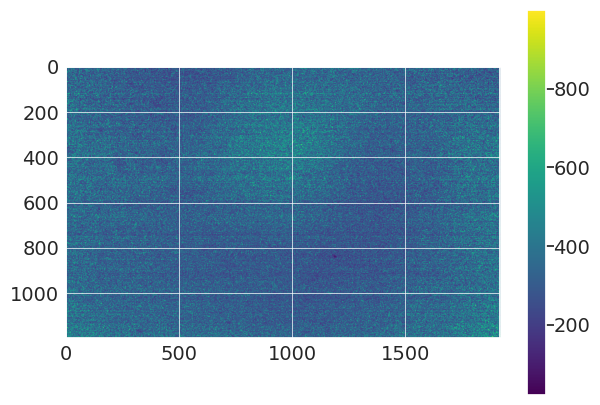

In [28]:
plt.imshow(ratios_conc_ims[0])
plt.colorbar()

findfont: Font family 'Lucida Sans Unicode' not found.
findfont: Font family 'Lucida Sans Unicode' not found.
findfont: Font family 'Lucida Sans Unicode' not found.
findfont: Font family 'Lucida Sans Unicode' not found.
findfont: Font family 'Lucida Sans Unicode' not found.
findfont: Font family 'Lucida Sans Unicode' not found.
findfont: Font family 'Lucida Sans Unicode' not found.
findfont: Font family 'Lucida Sans Unicode' not found.
findfont: Font family 'Lucida Sans Unicode' not found.
findfont: Font family 'Lucida Sans Unicode' not found.
findfont: Font family 'Lucida Sans Unicode' not found.
findfont: Font family 'Lucida Sans Unicode' not found.
findfont: Font family 'Lucida Sans Unicode' not found.
findfont: Font family 'Lucida Sans Unicode' not found.
findfont: Font family 'Lucida Sans Unicode' not found.
findfont: Font family 'Lucida Sans Unicode' not found.
findfont: Font family 'Lucida Sans Unicode' not found.
findfont: Font family 'Lucida Sans Unicode' not found.
findfont: 

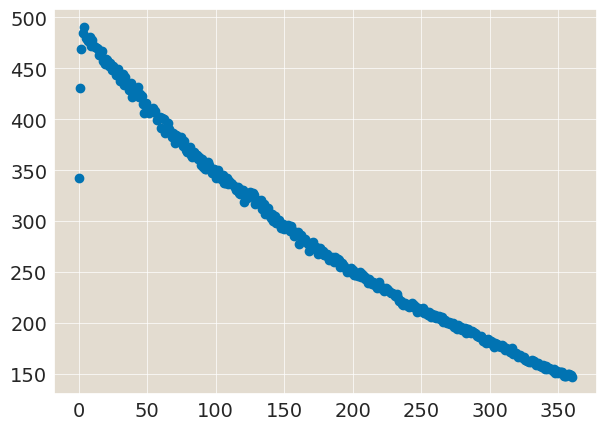

findfont: Font family 'Lucida Sans Unicode' not found.
findfont: Font family 'Lucida Sans Unicode' not found.
findfont: Font family 'Lucida Sans Unicode' not found.
findfont: Font family 'Lucida Sans Unicode' not found.
findfont: Font family 'Lucida Sans Unicode' not found.
findfont: Font family 'Lucida Sans Unicode' not found.
findfont: Font family 'Lucida Sans Unicode' not found.
findfont: Font family 'Lucida Sans Unicode' not found.
findfont: Font family 'Lucida Sans Unicode' not found.
findfont: Font family 'Lucida Sans Unicode' not found.
findfont: Font family 'Lucida Sans Unicode' not found.
findfont: Font family 'Lucida Sans Unicode' not found.
findfont: Font family 'Lucida Sans Unicode' not found.
findfont: Font family 'Lucida Sans Unicode' not found.
findfont: Font family 'Lucida Sans Unicode' not found.
findfont: Font family 'Lucida Sans Unicode' not found.
findfont: Font family 'Lucida Sans Unicode' not found.
findfont: Font family 'Lucida Sans Unicode' not found.
findfont: 

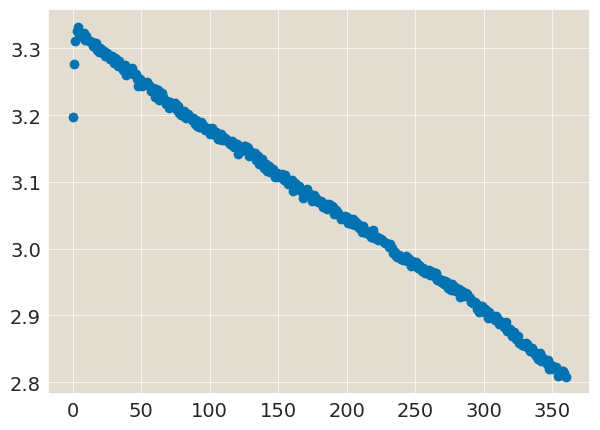

In [30]:
mean_ATP = np.mean(ratios_conc_ims, axis = (1, 2)); 
plt.plot(range(len(mean_ATP)), mean_ATP, 'o'); 

plt.figure()
ratios = bound_bs/unbound_bs; 
mean_ratios = np.mean(ratios, axis = (1, 2)); 
plt.plot(range(len(mean_ratios)), mean_ratios, 'o'); 

In [14]:
data_location

'../../data/atp_hydro/1000uM_ATP_0_ADP_0_P/'

In [15]:
plt.imshow(even_bound_bs[0]); 
plt.colorbar()

plt.figure()
plt.imshow(even_unbound_bs[0]); 
plt.colorbar()

NameError: name 'even_bound_bs' is not defined

In [16]:
# Stores results
linear_parameters_list = []; 
linear_r2_list = []; 
exponential_parameters_list = []; 
exponential_hydrolysis_rates_list = []; 
exp_r2_list = []; 
exponential_fit_start_time_list = []; 
linear_data_regime_list = []; 
ATP_data_list = []; 
ATP_std_data_list = []; 
Bound_data_list = []; 
Unbound_data_list = []; 
Ratio_list = []; 
Ratio_std_list = []; 
time_list = []; 

for i, folder in enumerate(tiff_folders): 
    print(f"File {i+1} of {len(tiff_folders)}")    
    
    # Record the start time
    linear_params, linear_r2, exp_params, rate, exp_r2, times, ratio_hydro_uM, atp_std, ratio_hydro, ratio_hydro_std, bound_hydro, unbound_hydro, linear_data_regime, exponential_fit_start_time = process_folder(folder)

    linear_parameters_list.append(linear_params); 
    linear_r2_list.append(linear_r2); 
    exponential_parameters_list.append(exp_params); 
    exponential_hydrolysis_rates_list.append(rate); 
    exp_r2_list.append(exp_r2);  
    linear_data_regime_list.append(linear_data_regime); 
    exponential_fit_start_time_list.append(exponential_fit_start_time); 
    ATP_data_list.append(ratio_hydro_uM); 
    ATP_std_data_list.append(atp_std); 
    Ratio_list.append(ratio_hydro); 
    Ratio_std_list.append(ratio_hydro_std); 
    Bound_data_list.append(bound_hydro); 
    Unbound_data_list.append(unbound_hydro); 
    time_list.append(times); 

NameError: name 'tiff_folders' is not defined

### Saving in CSV files

In [ ]:
#--------Collect conditions from file names ------# 

ATP_list = []; 
ADP_list = []; 
Phosphate_list = []; 
A81D_list = []; 
ExposureTime_405_list = []; 
ExposureTime_480_list = []; 
FrameInterval_list = []; 

for i, file in enumerate(tiff_folders): 
    split_file = file.split('/')

    # For ATP folder
    if split_file[3] == 'ATP': 
        ADP_list.append(0)
        Phosphate_list.append(0)
        ATP_list.append(int(split_file[-1].split("_")[0][:-5])) 
    
    # For ADP folder
    elif split_file[3] == 'ADP':
        Phosphate_list.append(0); 
        ADP_list.append(int(split_file[-1].split("_")[0][:-5]))
        ATP_list.append(int(split_file[4].split("_")[-1][:-5])) 

    # For Phosphate folder
    elif split_file[3] == 'Phosphate':
        
        ADP_list.append(0);    

        ATP_conc = int(split_file[4].split('_')[-1][:-5])
        ATP_list.append(ATP_conc)

        if split_file[5].split('_')[0] == "Nikon":
            P_conc = int(split_file[6].split('_')[0][:-4])
        else: 
            P_conc = int(split_file[5].split('_')[0][:-4])
        Phosphate_list.append(P_conc)

print(ATP_list)

In [ ]:
print(ATP_std_data_list)

In [ ]:
# Info below taken from file names (eg: Nikon_10X_bin1_20sFrameInterval_100ms480_150ms405_50uMATP_1uMmicro_1400nM_A81D_2). Stays constant for all experiments.
FrameInterval = 20; #seconds
Channel480ExposureTime = 100/1e3; #seconds
Channel405ExposureTime = 150/1e3; #seconds
A81D_conc = 1400; #nM 

df_anal = pd.DataFrame({'Data Location' : tiff_folders,
                        'ATP Concentration (uM)' : ATP_list, #convert into string
                        'ADP Concentration (uM)' : ADP_list,
                        'P Concentration (uM)' : Phosphate_list,
                        'NCD Micro Motor Concentration (uM)' : [1]*len(tiff_folders), # Same motor concentrations for this set of experiments
                        'r-squared for exponential fit' : exp_r2_list,
                        'Tau (s)' : [params[0] for params in exponential_parameters_list],
                        'A0 (uM)' : [params[1] for params in exponential_parameters_list],
                        'Ainf (uM)' : [params[2] for params in exponential_parameters_list],
                        'Exponential Fitting Start Time (seconds)' : exponential_fit_start_time_list, 
                        'Hydrolysis Rate (uM/s/motor) from Exponential Curve' : exponential_hydrolysis_rates_list,
                        'Linear Data Regime (start and end time in seconds)' : linear_data_regime_list,
                        'Hydrolysis Rate (uM/s/motor) from Linear Fitting (-abs(Slope)/Motconc)' : [-lparam[0]/Motconc for lparam in linear_parameters_list],
                        'Y-intercept of Linear Curve from Linear Fitting' : [lparam[1] for lparam in linear_parameters_list],
                        'r-squared for linear fit' : linear_r2_list,
                        'Cal_Param [Km, Rmax, Rmin, n]' : [[67.60201128,  3.36417414,  1.06783864,  1.17289855]]*len(tiff_folders), # Same callibration for each experiment 
                        'Frame Interval (s)': [20]*len(tiff_folders), 
                        '480 Channel Exposure Time (s)': [Channel480ExposureTime]*len(tiff_folders), 
                        '405 Channel Exposure Time (s)': [Channel405ExposureTime]*len(tiff_folders), 
                        'A81D Concentration (nM)': [A81D_conc]*len(tiff_folders),
                        'Time Array (s)': [list(time) for time in time_list], 
                        'ATP Curve (uM)':  [list(ATP) for ATP in ATP_data_list],
                        'ATP Curve Std (uM)':  [list(ATP_std) for ATP_std in ATP_std_data_list],
                        'Bound Curve':  [list(bound_array) for bound_array in Bound_data_list],
                        'Unbound Curve':  [list(unbound_array) for unbound_array in Unbound_data_list],
                        'Ratio (A.U.)':  [list(ratio) for ratio in Ratio_list],
                        'Standard Deviation in Ratio (A.U.)':  [list(ratio_std) for ratio_std in Ratio_std_list]
                        })

df_anal.to_csv('../../analyzed_data/atp-hydro/ATP_withstd.csv')